In [104]:
from functions import *
from architectures import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
data_lagged_features = pd.read_csv('data0305.csv')

In [106]:
data_lagged_features = data_lagged_features.drop(data_lagged_features.columns[data_lagged_features.columns.str.contains('lag')], axis=1)

In [107]:
data_lagged_features

,Unnamed: 0,Date,Store_id,SKU_id,Promo,Demand,Regular_Price,Actual_Price,weekday,monthday,is_weekend,month_period,demand_expanding_mean,Promo_percent
0,0,2015-01-01,1,1,0.0,22.0,163.78,163.78,3,1,0,0.0,NaN,0.000000
1,1,2015-01-01,53,1,0.0,3.0,163.78,163.78,3,1,0,0.0,NaN,0.000000
2,2,2015-01-01,54,1,0.0,6.0,163.78,163.78,3,1,0,0.0,NaN,0.000000
3,3,2015-01-01,49,1,0.0,6.0,163.78,163.78,3,1,0,0.0,NaN,0.000000
4,4,2015-01-01,55,1,0.0,16.0,163.78,163.78,3,1,0,0.0,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92881,92881,2016-06-19,92,2,0.0,NaN,133.06,133.06,6,19,1,1.0,25.199029,0.000000
92882,92882,2016-06-19,66,1,1.0,NaN,134.96,125.04,6,19,1,1.0,256.120079,0.073503
92883,92883,2016-06-19,30,1,1.0,NaN,134.96,125.04,6,19,1,1.0,211.535433,0.073503
92884,92884,2016-06-19,76,1,1.0,NaN,134.96,125.04,6,19,1,1.0,183.439834,0.073503


In [109]:
target = 'Demand'
id_cols = ['SKU_id', 'Store_id']
date_col = 'Date'

In [110]:
df_train, df_test, target_mean, target_stdev, features = preprocess(data_lagged_features, target, id_cols, date_col)

  0%|          | 0/2640 [00:00<?, ?it/s]

In [111]:
train_loader, test_loader, train_eval_loader = get_dataloaders(df_train, df_test, target, features)

In [112]:
params = {
    'learning_rate' : 1e-3,
    'weight_decay' : 1e-5,
    'num_hidden_units' : 64,
    'loss_function' : nn.L1Loss(),
    'gamma' : 0.95,
    'shape' : data_lagged_features.shape,
    'epochs' : 3
}

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=params['num_hidden_units'])
loss_function = params['loss_function']
optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=params['gamma'])

In [113]:
epochs = params['epochs']

train(df_train, epochs, train_loader, train_eval_loader, model,
      loss_function, optimizer, scheduler, target_mean, target_stdev)

Epoch 0
---------


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [01:13<00:00,  9.26it/s]


Train loss: 0.27340268170570625


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:36<00:00, 18.40it/s]


Smape = 85.67894353936775

Epoch 1
---------


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [02:10<00:00,  5.20it/s]


Train loss: 0.24008235249887494


 47%|█████████████████████████████████████▌                                          | 319/680 [00:13<00:15, 23.13it/s]


KeyboardInterrupt: 

In [92]:
df_out = get_df_out(model, df_train, df_test, train_eval_loader, test_loader, target, target_mean, target_stdev)
ans = get_submission('test_kaggle.csv', df_out, target, id_cols, date_col)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.33it/s]


<AxesSubplot:xlabel='Date'>

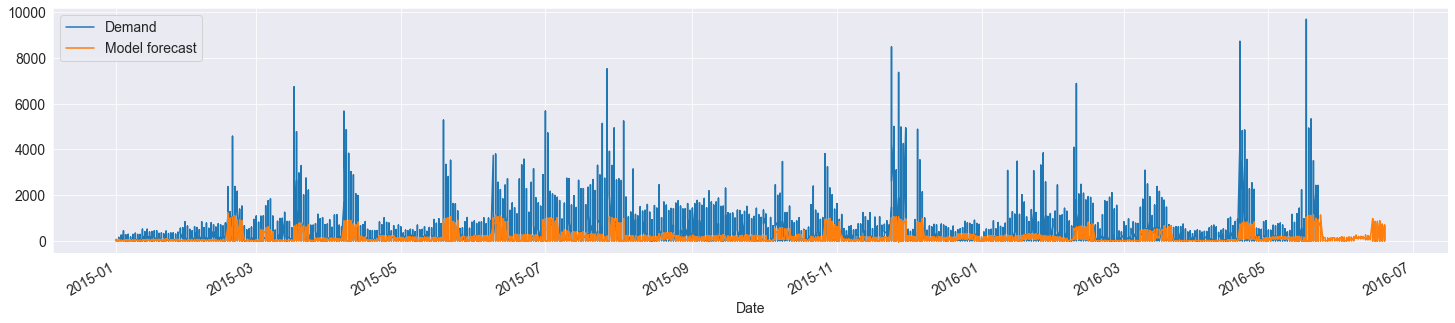

In [93]:
df_out.reset_index().drop(['Store_id', 'SKU_id'], axis=1).set_index('Date').sort_index().plot()

In [98]:
df_train

Unnamed: 0     Promo    Demand  Regular_Price  \
Date       SKU_id Store_id                                                  
2015-01-01 1      1          -1.732021 -0.463107 -0.466360       2.675922   
                  53         -1.731981 -0.463107 -0.518151       2.675922   
                  54         -1.731941 -0.463107 -0.509973       2.675922   
                  49         -1.731901 -0.463107 -0.509973       2.675922   
                  55         -1.731861 -0.463107 -0.482715       2.675922   
...                                ...       ...       ...            ...   
2016-05-22 1      27          1.731861  2.159304  0.065178      -1.114586   
                  84          1.731901  2.159304  2.052314      -1.114586   
           2      89          1.731941 -0.463107 -0.490893      -0.077642   
                  63          1.731981 -0.463107 -0.526329       0.365673   
           1      100         1.732021  2.159304  1.144610      -1.114586   

                            Actual_Price   weekday  monthday  is_weekend  \
Date       SKU_id Store_id                                                 
2015-01-01 1      1             2.252280 -0.006865 -1.663653   -0.635749   
                  53            2.252280 -0.006865 -1.663653   -0.635749   
                  54            2.252280 -0.006865 -1.663653   -0.635749   
                  49            2.252280 -0.006865 -1.663653   -0.635749   
                  55            2.252280 -0.006865 -1.663653   -0.635749   
...                                  ...       ...       ...         ...   
2016-05-22 1      27           -1.351967  1.493677  0.741565    1.572930   
                  84           -1.351967  1.493677  0.741565    1.572930   
           2      89            0.189913  1.493677  0.741565    1.572930   
                  63            0.521948  1.493677  0.741565    1.572930   
           1      100          -1.351967  1.493677  0.741565    1.572930   

                            month_period  demand_expanding_mean  Promo_percent  
Date       SKU_id Store_id                                                      
2015-01-01 1      1            -1.066295               0.270987      -0.391474  
                  53           -1.066295               0.321546      -0.391474  
                  54           -1.066295               0.998315      -0.391474  
                  49           -1.066295               0.080795      -0.391474  
                  55           -1.066295               0.487501      -0.391474  
...                                  ...                    ...            ...  
2016-05-22 1      27            0.937816               0.233712       0.902443  
                  84            0.937816               0.374499       0.902443  
           2      89            0.937816              -0.674788      -0.391474  
                  63            0.937816              -0.724786      -0.391474  
           1      100           0.937816              -0.070052       0.902443  

[86916 rows x 11 columns]